In [42]:
# you can see the ZeroDCE model does a very good job of predicting the colors of the stadium and enhancing it.
# That's it for this video. see you in the next one
import transformers
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
from huggingface_hub import from_pretrained_keras
from google.colab import files

# Download the image
!wget https://upload.wikimedia.org/wikipedia/commons/0/09/Low_light_%2839747320674%29.jpg -O low_light.jpg

# Install required packages
!pip install transformers huggingface_hub

# Load the model
model = from_pretrained_keras("keras-io/low-light-image-enhancement")

# Create inference function
def inference(o_image):
    # Preprocess for the model
    image = keras.preprocessing.image.img_to_array(o_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0) # Create batch of 1 image
    print(image.shape) # Should be (1, H, W, C)
    output_image = model(image) # Run the image through model
    output_image = post_process(image, output_image) # Apply post-processing
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8) # Processing for PIL.Image
    output_image = Image.fromarray(output_image.numpy())
    return output_image

# Define post-processing function
def post_process(image, output):
    # From zero_dce post process
    r1 = output[:, :, :, :3]
    r2 = output[:, :, :, 3:6]
    r3 = output[:, :, :, 6:9]
    r4 = output[:, :, :, 9:12]
    r5 = output[:, :, :, 12:15]
    r6 = output[:, :, :, 15:18]
    r7 = output[:, :, :, 18:21]
    r8 = output[:, :, :, 21:24]
    x = image + r1 * (tf.square(image) - image)
    x = x + r2 * (tf.square(x) - x)
    enhanced_img = x + r4 * (tf.square(x) - x)
    x = enhanced_img + r5 * (tf.square(enhanced_img) - enhanced_img)
    x = x + r6 * (tf.square(x) - x)
    x = x + r7 * (tf.square(x) - x)
    enhanced_img = x + r8 * (tf.square(x) - x)
    return enhanced_img

# Load the original image
orig = Image.open("low_light.jpg")

# Enhance the image
enhanced = inference(orig)


# Save the enhanced image
enhanced.save("enhanced_image.jpg")

x = Image.open("enhanced_image.jpg")

# Download the enhanced image
files.download("enhanced_image.jpg")


--2024-07-24 18:06:15--  https://upload.wikimedia.org/wikipedia/commons/0/09/Low_light_%2839747320674%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 615570 (601K) [image/jpeg]
Saving to: ‘low_light.jpg’

low_light.jpg       100%[===================>] 601.14K  --.-KB/s    in 0.1s    

2024-07-24 18:06:15 (5.14 MB/s) - ‘low_light.jpg’ saved [615570/615570]



Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

(1, 2592, 3872, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[0.00026475 0.00140172 0.00381028 0.00531767 0.00381028 0.00140172
  0.00026475]
 [0.00140172 0.00742141 0.02017349 0.02815437 0.02017349 0.00742141
  0.00140172]
 [0.00381028 0.02017349 0.05483722 0.07653151 0.05483722 0.02017349
  0.00381028]
 [0.00531767 0.02815437 0.07653151 0.10680833 0.07653151 0.02815437
  0.00531767]
 [0.00381028 0.02017349 0.05483722 0.07653151 0.05483722 0.02017349
  0.00381028]
 [0.00140172 0.00742141 0.02017349 0.02815437 0.02017349 0.00742141
  0.00140172]
 [0.00026475 0.00140172 0.00381028 0.00531767 0.00381028 0.00140172
  0.00026475]]


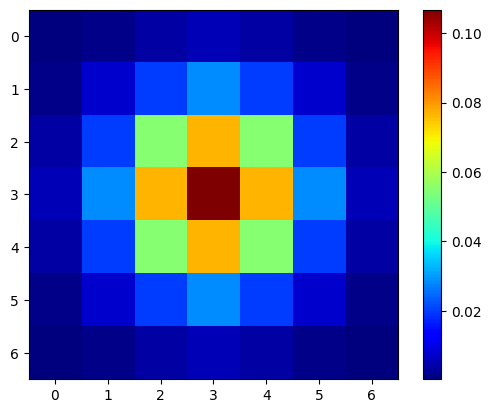

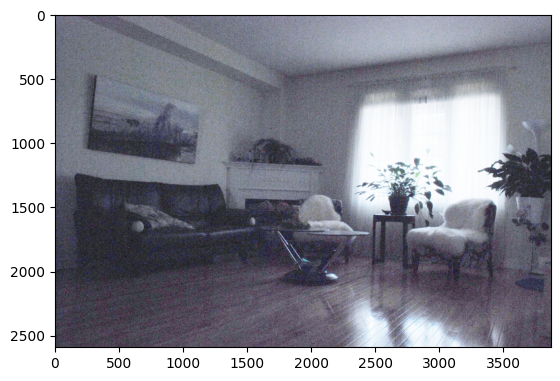

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float, io
from scipy import ndimage as nd
import os

def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()

# Create and visualize the Gaussian kernel
gaussian_kernel_array = gaussian_kernel(3)
print(gaussian_kernel_array)
plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.colorbar()
plt.show()

# Load the enhanced image
img = img_as_float(io.imread("enhanced_image.jpg"))

# Apply Gaussian filter
gaussian_img = nd.gaussian_filter(img, sigma=3)

# Create directory to save images if it doesn't exist
os.makedirs("images", exist_ok=True)

# Save the filtered images
plt.imsave("images/gaussian.jpg", gaussian_img)

# Apply median filter
median_img = nd.median_filter(img, size=3)
plt.imsave("images/median.jpg", median_img)

# Apply Non-Local Means denoising
sigma_est = np.mean(estimate_sigma(img, channel_axis=-1))
patch_kw = dict(patch_size=5, patch_distance=3, channel_axis=-1)
denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False, **patch_kw)
denoise_img_as_8byte = img_as_ubyte(denoise_img)
plt.imsave("images/NLM.jpg", denoise_img_as_8byte)

# Visualize the denoised image
plt.imshow(denoise_img)
plt.show()
